# Allen-Cahn Equation Comparison: PINN vs Numerical

Reference (Spectral) solve time: 0.049s
PINN train time:                 135.260s (loss PDE=2.02e-03, IC=5.38e-03, BC=1.10e-03)
PINN eval time:                  0.011s


/Users/josegarcia/Documents/Cursor/PINNs-RL-PDE/pinn/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning: divide by zero encountered in matmul
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))
/Users/josegarcia/Documents/Cursor/PINNs-RL-PDE/pinn/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning: overflow encountered in matmul
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))


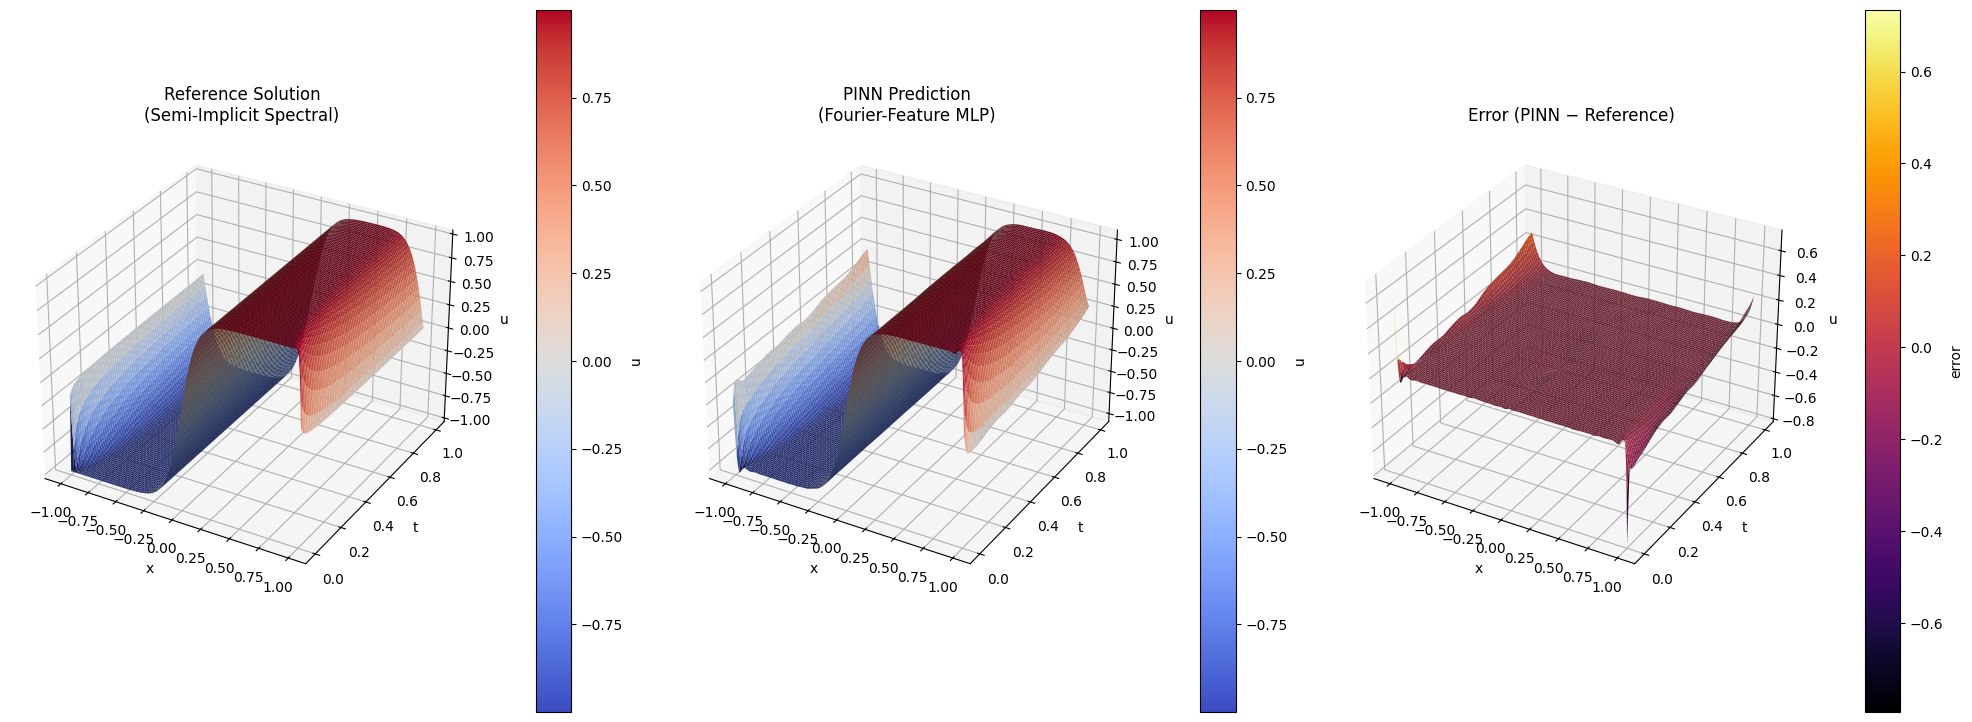

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import cm
import time
from scipy.special import iv
import matplotlib.gridspec as gridspec

# ----------------------------------------
# 1) Semi‐implicit spectral solver for Allen–Cahn (reference)
# ----------------------------------------
def allen_cahn_spectral(u0, eps, t_vals, x, dt=5e-4):
    """
    Semi‐implicit Euler:
      u_t = eps*u_xx + u - u^3
    on periodic x, spectral diff.
    Returns U_ref shape (len(x), len(t_vals)).
    """
    N  = x.size
    dx = x[1] - x[0]
    k  = np.fft.fftfreq(N, d=dx) * 2*np.pi
    U = np.zeros((len(x), len(t_vals)))
    u = u0.copy()
    t = 0.0
    idx = 0
    max_steps = int(np.ceil(max(t_vals)/dt)) + 1
    for _ in range(max_steps):
        if t >= t_vals[idx] - 1e-8:
            U[:, idx] = u
            idx += 1
            if idx == len(t_vals):
                break
        # nonlinear term
        NL = u - u**3
        u_hat  = np.fft.fft(u)
        nl_hat = np.fft.fft(NL)
        denom = 1 + dt * eps * (k**2)
        u_hat_new = (u_hat + dt*nl_hat) / denom
        u = np.real(np.fft.ifft(u_hat_new))
        t += dt
    return U

# ----------------------------------------
# 2) PINN for Allen–Cahn
# ----------------------------------------
class FourierFeatures(nn.Module):
    def __init__(self, in_dim, m=100, scale=1.0):
        super().__init__()
        B = torch.randn(in_dim, m) * scale
        self.register_buffer('B', B)
    def forward(self, x):
        proj = 2*torch.pi * x @ self.B
        return torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)

class PINNAllenCahn(nn.Module):
    def __init__(self, eps, hidden=[128,128], m=100):
        super().__init__()
        self.eps = eps
        self.ff  = FourierFeatures(2, m, scale=np.pi)  # domain [-1,1]
        layers=[]
        dim = 2*m
        for h in hidden:
            layers += [nn.Linear(dim,h), nn.Tanh()]
            dim = h
        layers += [nn.Linear(dim,1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x, t):
        inp = torch.cat([x,t], dim=-1)
        return self.net(self.ff(inp))
    def loss_pde(self, x, t):
        x.requires_grad_(True); t.requires_grad_(True)
        u    = self.forward(x,t)
        u_t  = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x  = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        f = u_t - (self.eps*u_xx + u - u**3)
        return torch.mean(f**2)
    def loss_ic(self, x0):
        u0 = torch.tanh(x0/np.sqrt(2*self.eps))
        return torch.mean((self.forward(x0,torch.zeros_like(x0)) - u0)**2)
    def loss_bc(self, tb):
        xL = torch.ones_like(tb); x0 = -xL
        u0 = self.forward(x0,tb); uL = self.forward(xL,tb)
        return torch.mean((u0 - uL)**2)
    def train_model(self, epochs, lr, N_pde, N_ic, N_bc, t_max, device):
        self.to(device)
        opt = optim.Adam(self.parameters(), lr=lr)
        last_lp = last_li = last_lb = None
        for ep in range(1, epochs+1):
            x_p = (2*torch.rand(N_pde,1)-1).to(device) #collocation points for PDE
            t_p =  torch.rand(N_pde,1).to(device) * t_max #collocation points for PDE
            x_i = (2*torch.rand(N_ic,1)-1).to(device) #collocation points for IC
            t_b =  torch.rand(N_bc,1).to(device) * t_max #collocation points for BC
            lp = self.loss_pde(x_p, t_p)
            li = self.loss_ic(x_i)
            lb = self.loss_bc(t_b)
            loss = lp + li + lb
            opt.zero_grad(); loss.backward(); opt.step()
            last_lp, last_li, last_lb = lp.item(), li.item(), lb.item()
        return last_lp+last_li+last_lb, last_lp, last_li, last_lb

# ----------------------------------------
# 3) Compare & 3D surface plot
# ----------------------------------------
if __name__=='__main__':
    # grid
    x      = np.linspace(-1,1,256)
    t_vals = np.linspace(0,1,80)
    X, T   = np.meshgrid(x, t_vals, indexing='ij')  # X,Nx x Nt

    eps = 0.01
    U0  = np.tanh(x/np.sqrt(2*eps))

    # reference solve
    t0 = time.time()
    U_ref = allen_cahn_spectral(U0, eps, t_vals, x)  # shape Nx x Nt
    t_ref = time.time() - t0

    # PINN train
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pinn = PINNAllenCahn(eps).to(device)
    t0 = time.time()
    sum_loss, lpde, lic, lbc = pinn.train_model(
        epochs=5000, lr=1e-3,
        N_pde=3000, N_ic=500, N_bc=500, #N_pde=3000, N_ic=500, N_bc=500, epochs=5000, lr=1e-3,
        t_max=1.0, device=device
    )
    t_pinn = time.time() - t0

    # PINN eval
    t0 = time.time()
    XX = torch.tensor(X.reshape(-1,1),dtype=torch.float32,device=device)
    TT = torch.tensor(T.reshape(-1,1),dtype=torch.float32,device=device)
    with torch.no_grad():
        U_pn = pinn(XX,TT).cpu().numpy().reshape(X.shape)
    t_eval = time.time() - t0

    U_err = U_pn - U_ref

    print(f"Reference (Spectral) solve time: {t_ref:.3f}s")
    print(f"PINN train time:                 {t_pinn:.3f}s (loss PDE={lpde:.2e}, IC={lic:.2e}, BC={lbc:.2e})")
    print(f"PINN eval time:                  {t_eval:.3f}s")

    fig = plt.figure(figsize=(20,12))
    for i,(surf,title) in enumerate([
        (U_ref, "Reference Solution\n(Semi-Implicit Spectral)"),
        (U_pn,  "PINN Prediction\n(Fourier-Feature MLP)"),
        (U_err, "Error (PINN − Reference)")
    ]):
        ax = fig.add_subplot(1,3,i+1, projection='3d')
        norm = cm.colors.Normalize(vmin=U_ref.min(), vmax=U_ref.max())
        cmap = cm.coolwarm if i<2 else cm.inferno
        surf_plot = ax.plot_surface(
            X, T, surf,
            facecolors=cmap(norm(surf if i<2 else U_err)),
            rcount=150, ccount=100,
            linewidth=0, antialiased=True
        )
        ax.set_title(title, fontsize=12)
        ax.set_xlabel('x'); ax.set_ylabel('t'); ax.set_zlabel('u')
        if i<2:
            fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.coolwarm),
                         ax=ax, shrink=0.6, pad=0.1, label='u')
        else:
            err_norm = cm.colors.Normalize(vmin=U_err.min(), vmax=U_err.max())
            fig.colorbar(cm.ScalarMappable(norm=err_norm, cmap=cm.inferno),
                         ax=ax, shrink=0.6, pad=0.1, label='error')
    plt.tight_layout()
    plt.show()


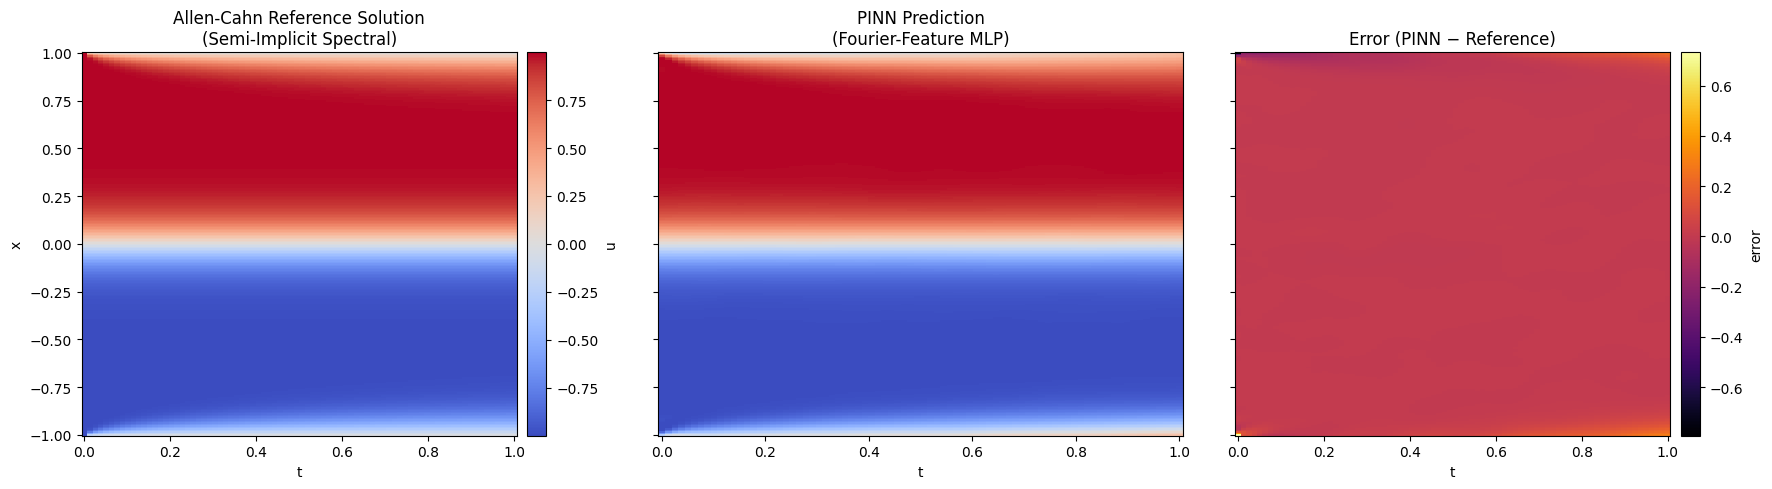

In [9]:
X_plot, T_plot = np.meshgrid(x, t_vals, indexing='ij')

fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
vmin, vmax = U_ref.min(), U_ref.max()

# 1) Reference (semi-implicit spectral)
im0 = axs[0].pcolormesh(
    T_plot, X_plot, U_ref,
    cmap='coolwarm', vmin=vmin, vmax=vmax,
    shading='auto'
)
axs[0].set_title("Allen-Cahn Reference Solution\n(Semi-Implicit Spectral)")
axs[0].set_xlabel("t")
axs[0].set_ylabel("x")
fig.colorbar(im0, ax=axs[0], pad=0.02, label='u')

# 2) PINN prediction
im1 = axs[1].pcolormesh(
    T_plot, X_plot, U_pn,
    cmap='coolwarm', vmin=vmin, vmax=vmax,
    shading='auto'
)
axs[1].set_title("PINN Prediction\n(Fourier-Feature MLP)")
axs[1].set_xlabel("t")
# share the same colorbar limits, so no new colorbar

# 3) Error
im2 = axs[2].pcolormesh(
    T_plot, X_plot, U_err,
    cmap='inferno', shading='auto'
)
axs[2].set_title("Error (PINN − Reference)")
axs[2].set_xlabel("t")
fig.colorbar(im2, ax=axs[2], pad=0.02, label='error')

plt.tight_layout()
plt.show()

/var/folders/yx/b_pyg98x1dj97pbflpck32d80000gn/T/ipykernel_4884/1260861200.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.95])


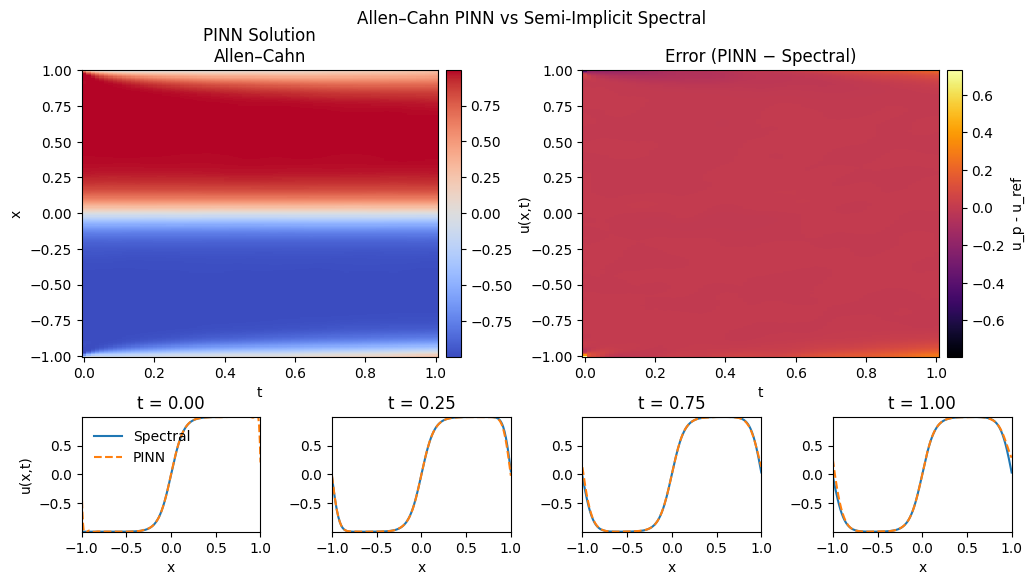

In [14]:
# compute the error
U_err = U_pn - U_ref

# choose the four time‐snapshots to plot below
snap_times = [0.0, 0.25, 0.75, 1.0]
# find nearest indices in t_vals
snap_idx = [np.argmin(np.abs(t_vals - tt)) for tt in snap_times]

# set up grid: 2 rows, first row spans 4 cols but we use 2 panels,
# second row uses all 4 small panels
fig = plt.figure(figsize=(12, 6))
gs  = gridspec.GridSpec(2, 4, height_ratios=[1,0.4], hspace=0.3, wspace=0.4)

# Top‐left: PINN solution heatmap
ax0 = fig.add_subplot(gs[0, 0:2])
pcm0 = ax0.pcolormesh(
    t_vals, x, U_pn,
    cmap='coolwarm',
    vmin=U_ref.min(), vmax=U_ref.max(),
    shading='auto'
)
ax0.set_title("PINN Solution\nAllen–Cahn")
ax0.set_xlabel("t"); ax0.set_ylabel("x")
cbar0 = fig.colorbar(pcm0, ax=ax0, pad=0.02, label="u(x,t)")

# Top‐right: error heatmap
ax1 = fig.add_subplot(gs[0, 2:4])
pcm1 = ax1.pcolormesh(
    t_vals, x, U_err,
    cmap='inferno',
    shading='auto'
)
ax1.set_title("Error (PINN − Spectral)")
ax1.set_xlabel("t")
cbar1 = fig.colorbar(pcm1, ax=ax1, pad=0.02, label="u_p - u_ref")

# Bottom row: four line plots
axes = [fig.add_subplot(gs[1, i]) for i in range(4)]
for ax, idx, tt in zip(axes, snap_idx, snap_times):
    ax.plot(x, U_ref[:, idx],  label="Spectral", color="C0")
    ax.plot(x, U_pn[:,  idx],  label="PINN",     color="C1", linestyle="--")
    ax.set_title(f"t = {tt:.2f}")
    ax.set_xlim(-1,1)
    ax.set_ylim(U_ref.min(), U_ref.max())
    if ax is axes[0]:
        ax.set_ylabel("u(x,t)")
        ax.legend(loc="upper left", frameon=False)
    ax.set_xlabel("x")

plt.suptitle("Allen–Cahn PINN vs Semi-Implicit Spectral", y=0.98)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

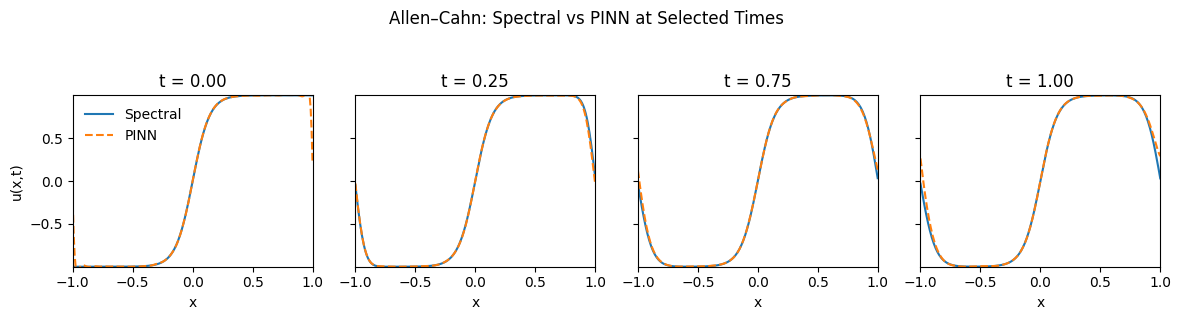

In [16]:
# Assuming these arrays are defined:
# x      : shape (Nx,) spatial grid
# t_vals : shape (Nt,) time grid
# U_ref  : shape (Nx, Nt) reference (spectral) solution
# U_pn   : shape (Nx, Nt) PINN prediction

# Choose snapshot times for the line plots
snap_times = [0.0, 0.25, 0.75, 1.0]
snap_idx   = [np.argmin(np.abs(t_vals - tt)) for tt in snap_times]

# Create a row of four subplots
fig, axes = plt.subplots(1, 4, figsize=(12, 3), sharey=True)

for ax, idx, tt in zip(axes, snap_idx, snap_times):
    ax.plot(x, U_ref[:, idx], label="Spectral", color="C0")
    ax.plot(x, U_pn[:,  idx], label="PINN",     color="C1", linestyle="--")
    ax.set_title(f"t = {tt:.2f}")
    ax.set_xlim(-1, 1)
    ax.set_ylim(U_ref.min(), U_ref.max())
    ax.set_xlabel("x")
    
# Label the first subplot's y-axis and add legend
axes[0].set_ylabel("u(x,t)")
axes[0].legend(loc="upper left", frameon=False)

plt.suptitle("Allen–Cahn: Spectral vs PINN at Selected Times", y=1.05)
plt.tight_layout()
plt.show()
